In [1]:
import numpy as np
import pandas as pd

In [2]:
data_directory = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Chakla_C66.csv'
file_name = ''
file_path = data_directory + file_name
turbine_state = 11

data_set = pd.read_csv(file_path)[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState']]
data_set = data_set[data_set['ActivePower'] > 0]
data_set = data_set[data_set['TurbineState'] == turbine_state]
min_WindSpeed = data_set['WindSpeed'].min()
min_ActivePower = data_set['ActivePower'].min()
normalize_WindSpeed_factor = data_set['WindSpeed'].max() - min_WindSpeed
normalize_ActivePower_factor = data_set['ActivePower'].max() - min_ActivePower
data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_WindSpeed) * 100 / normalize_WindSpeed_factor)
data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_ActivePower) * 100 / normalize_ActivePower_factor)

def rounding_method(multiply_factor, round_off_by_factor):
    return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor

data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(1, 2))
data_set.index = pd.to_datetime(data_set['Timestamp'])
del data_set['Timestamp']

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])

In [4]:
from sklearn.cluster import KMeans, DBSCAN
n_kmeans_clusters = 14
kmeans_alg_obj = KMeans(n_clusters=n_kmeans_clusters)
dbscan_alg_obj = DBSCAN(eps=0.7, min_samples=1)
dbscan_alg_obj_dt = DBSCAN(eps=0.7, min_samples=2)
previous_width = -1
threshold_width_deviation = 1.8
allowed_width_deviation = threshold_width_deviation
epsilon_deviation = 0.33
change_width_for = {}
weight_min_width = 0.9
weight_max_width = 0.1
weight_max_deviation = 0.6
weight_min_deviation = 0.4
allowed_group_wind_speed_deviation = 0.13
min_points_in_group = 4
limit_elements_in_group_std = 1.6
limit_next_center_std = 0.5
right_most_dbkstd_limit = 1.4
left_most_dbkstd_limit = 1.4
dt_score = pd.DataFrame()
tbs = 0
tbsd = 0
from scipy.stats import norm
for group in data_set.groupby('discrete_ActivePower'):

    work_group = group[1].copy()
    work_group['dbscan_label'] = dbscan_alg_obj.fit_predict(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    work_group = work_group[work_group['dbscan_label'] != -1].copy()

    if work_group.shape[0] <= n_kmeans_clusters:
        continue


    kmeans_alg_obj.fit(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    work_group['kmeans_label'] = kmeans_alg_obj.labels_
    label_positions = [i[0] for i in sorted(enumerate(kmeans_alg_obj.cluster_centers_[:,0]), key=lambda x:x[1])]
    sorted_values = np.sort(kmeans_alg_obj.cluster_centers_[:,0], axis=0)
    current_width = sorted_values[-1] - sorted_values[0]

    for grp in work_group.groupby('dbscan_label'):
        plt.scatter(grp[1]['scaled_WindSpeed'], grp[1]['discrete_ActivePower'])



    if previous_width == -1:
        previous_width = current_width
        continue

    if np.std([previous_width, current_width]) < allowed_width_deviation:
        allowed_width_deviation = weight_min_deviation * np.min([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation]) \
                                + weight_max_deviation * np.max([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation])
        plt.scatter(work_group['scaled_WindSpeed'].min(), group[0], c='#ff0000')
        plt.scatter(work_group['scaled_WindSpeed'].max(), group[0], c='#ff0000')
        previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])


        continue

    m = 0
    n = -1



    while (np.std([previous_width, current_width]) > allowed_width_deviation) and (current_width > previous_width):
        _group_kmeans_filter_m = work_group[work_group['kmeans_label'] == label_positions[m]]

        if ((n < -(n_kmeans_clusters - 2))
                or (((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) < allowed_group_wind_speed_deviation)
                        or (_group_kmeans_filter_m.shape[0] < min_points_in_group))
                    and np.std([sorted_values[m], sorted_values[m + 1]]) > limit_next_center_std)):
            m = m + 1
            n = -1

        if ((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) > limit_elements_in_group_std) 
                and (work_group[work_group['kmeans_label'] == label_positions[m]].shape[0] < min_points_in_group)):
            n = m
            break

        if m > (n_kmeans_clusters - 2):
            m = 0
            n = -1
            break

        n = n - 1
        current_width = sorted_values[n] - sorted_values[m]


    change_width_for[group[0]] = {}

    _max_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].idxmax()]['dbscan_label']
    _min_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].idxmin()]['dbscan_label']

    right_most_opt_dbscan = work_group[work_group['dbscan_label'] == _max_dbscan_label]['scaled_WindSpeed'].max()
    right_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].max()

    left_most_opt_dbscan = work_group[work_group['dbscan_label'] == _min_dbscan_label]['scaled_WindSpeed'].min()
    left_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].min()

    if np.std([right_most_opt_dbscan, right_most_opt_kmeans]) < right_most_dbkstd_limit:
        right_most = right_most_opt_dbscan
    else:
        right_most = right_most_opt_kmeans

    if np.std([left_most_opt_dbscan, left_most_opt_kmeans]) < left_most_dbkstd_limit:
        left_most = left_most_opt_dbscan
    else:
        left_most = left_most_opt_kmeans

    dt_df = work_group[(work_group['scaled_WindSpeed'] >= left_most) & (work_group['scaled_WindSpeed'] <= right_most)]

    blank_score = 0
    _wind_speed_list = np.sort(dt_df['scaled_WindSpeed'])
    max_gap = 0
    max_gap_i = -2
    for i in range(len(_wind_speed_list) - 1):
        if _wind_speed_list[i + 1] - _wind_speed_list[i] > max_gap:
            max_gap = _wind_speed_list[i + 1] - _wind_speed_list[i]
            max_gap_i = i

    mid = _wind_speed_list[max_gap_i] * 0.5 + _wind_speed_list[max_gap_i + 1] * 0.5

    for i in range(len(_wind_speed_list) - 1):
        blank_score = blank_score + (_wind_speed_list[i + 1] - _wind_speed_list[i]) * norm(mid, 2).pdf((_wind_speed_list[i + 1] + _wind_speed_list[i]) / 2)

    print blank_score, group[0]
    tbs = tbs + blank_score
    tbsd = tbsd + 1


    change_width_for[group[0]]['l'] = left_most
    change_width_for[group[0]]['r'] = right_most
    previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])

    m = 0
    n = -1

for x in change_width_for.keys():
    plt.scatter(change_width_for[x]['l'], x, c='#000000')
    plt.scatter(change_width_for[x]['r'], x, c='#000000')



0.753211748242 34
0.6501653697 42
0.552340644539 46
0.609746442864 48
0.568226580015 50
0.63377485663 52
0.816176122912 54
0.854324448977 56
0.555220106944 58
0.87371951451 60
0.988455014672 62
0.966851748257 64
0.980342703855 66
0.58462274245 68
0.99149591392 70
0.995279943016 72
0.863516681088 74
0.988611267265 76
0.994759593634 78
0.984533529764 80
0.986935791423 82
1.00144298719 84
0.83170655804 86
1.04231649703 88
1.00103804824 90
0.995763996024 92
1.01134262532 94
1.01830637469 96
0.97514895089 98
1.00113933577 100


0.869017204596


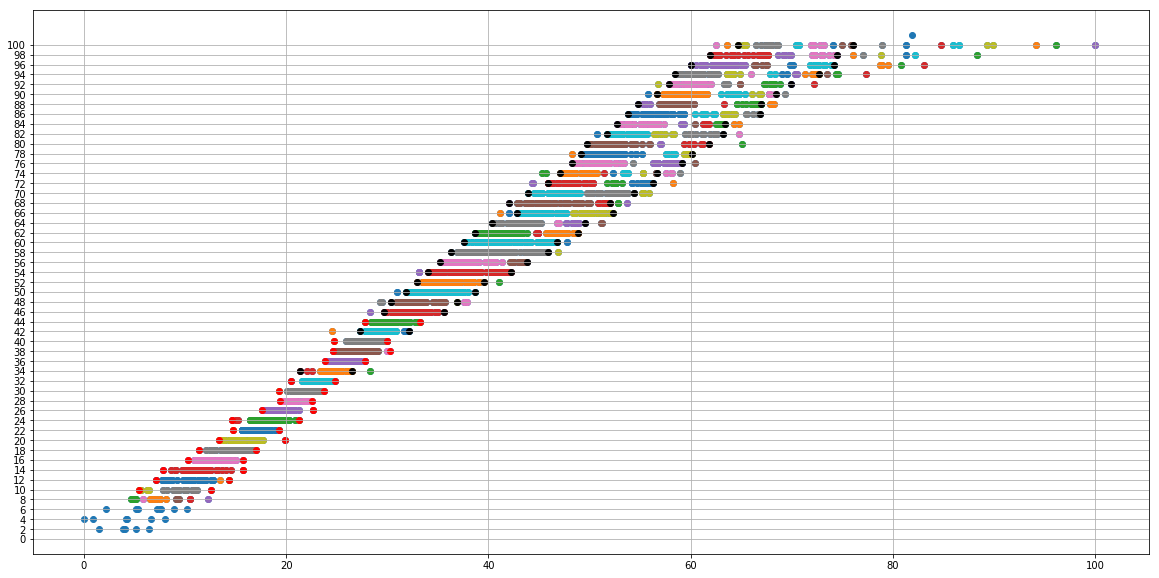

In [5]:
plt.yticks(np.arange(0, 102, 2))
plt.grid(True)
print tbs / tbsd
plt.show()